# WeatherPy - Weather Visualization

### Dependencies and data

In [10]:
%matplotlib inline

import datetime as dt
import gmaps
import requests
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import config

In [11]:
# Configure API key
gmaps.configure(api_key=config.GMAPS_API_KEY)

In [12]:
# Weather data
weather = pd.read_csv('data/weather.csv')
print(weather.info())
weather.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           1023 non-null   int64  
 1   City         1023 non-null   object 
 2   Country      1016 non-null   object 
 3   Latitude     1023 non-null   float64
 4   Longitude    1023 non-null   float64
 5   Time         1023 non-null   object 
 6   Description  1023 non-null   object 
 7   Max Temp     1023 non-null   float64
 8   Humidity     1023 non-null   int64  
 9   Wind Speed   1023 non-null   float64
 10  Cloudiness   1023 non-null   int64  
 11  Rain         1023 non-null   float64
 12  Snow         1023 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 104.0+ KB
None


,ID,City,Country,Latitude,Longitude,Time,Description,Max Temp,Humidity,Wind Speed,Cloudiness,Rain,Snow
0,0,Garoowe,SO,8.4054,48.4845,2021-01-09 20:45:48,clear sky,66.99,64,16.51,0,0.0,0.0
1,1,Vendas Novas,PT,38.6771,-8.4579,2021-01-09 20:45:49,few clouds,43.00,65,11.50,20,0.0,0.0


In [13]:
# Split northern and southern hemispheres
north_weather = weather[weather['Latitude'] >= 0]
south_weather = weather[weather['Latitude'] < 0]
north_weather.shape[0], south_weather.shape[0]

(705, 318)

### How does weather change with changing latitudes?

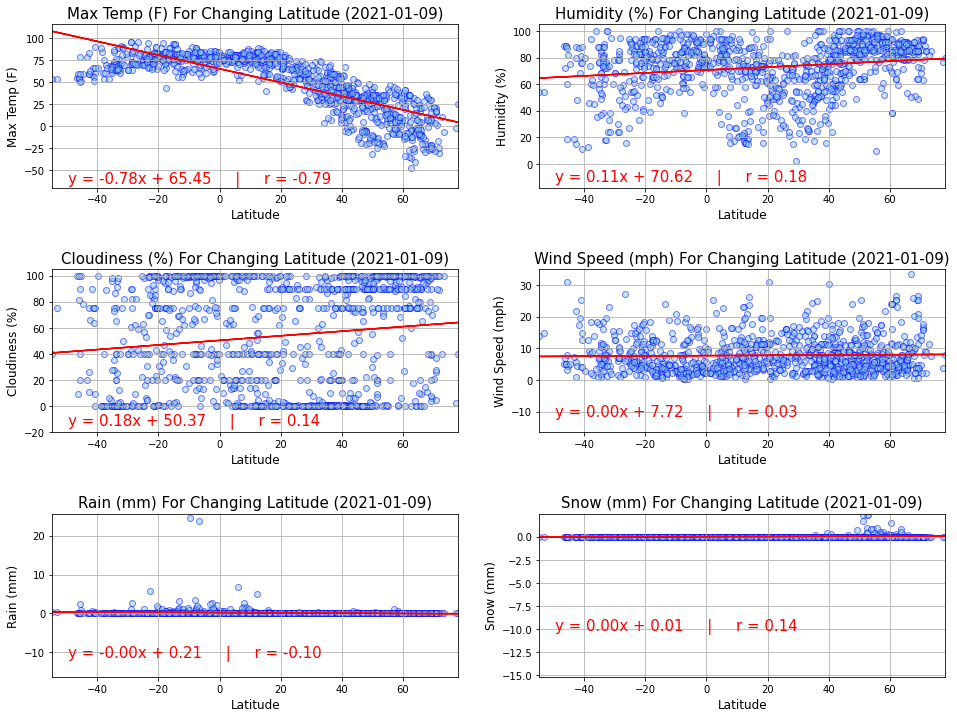

In [17]:
# Get weather date
w_date = weather.loc[0, 'Time'][:10]

def weather_linreg(y, x='Latitude', data=weather, ax=plt, text_loc=None, date=w_date, x_suffix=''):
    
    """
    Plot a weather feature against the latitude, including the regression line.
    
    Args:
        [1] y (str) - name of weather feature
        [2] x (str) - name of latitude feature
        [3] data (Pandas dataframe) - weather data
        [4] ax (Matplotlib axis) - axis to plot on
        [5] text_loc (tuple(int, int)) - coordinates for text annotation
        [6] date (str) - date of the weather data
        [7] x_suffix (str) - suffix to add to x-label
    """
    
    # Linear regression
    m, b, r, p, s = linregress(data[x], data[y]) # slope, y-int, correlation coef, p-val, stderr
    line = m * data[x] + b # regression line
    eq = f'y = {m:.2f}x + {b:.2f}     |     r = {r:.2f}' # regression equation and correlation coef
    
    # Plot points and line
    ax.scatter(data[x], data[y], alpha=0.5, c='skyblue', edgecolor='blue')
    ax.plot(data[x], line, c='red')
    
    # Annotate equation and correlation
    try: # only works if ax is an axis, not the pyplot module
        if text_loc is None:
            ax.set_xlim(data[x].min(), data[x].max())
            ax.set_ylim(ax.get_ylim()[0] - 15, ax.get_ylim()[1])
            text_loc = (ax.get_xlim()[0] + 5, ax.get_ylim()[0] + 5)
        ax.annotate(eq, text_loc, c='red', fontsize=15)
    except:
        print('No annotation')
    
    # Add units to y-label
    if y == 'Max Temp':
        y += ' (F)' # degrees Fahrenheit
    elif y == 'Wind Speed':
        y += ' (mph)' # miles per hour
    elif y in 'Rain Snow':
        y += ' (mm)' # millimeters of rain or snow
    else:
        y += ' (%)' # percent humidity or cloudiness
    
    # Formatting
    ax.set_title(f"{y} For Changing {x} ({date})", fontsize=15)
    ax.set_ylabel(y, fontsize=12)
    ax.set_xlabel(x + x_suffix, fontsize=12)
    ax.grid()
    
    
# Figure and axes
weather_feats, j = ['Max Temp', 'Humidity', 'Cloudiness', 'Wind Speed', 'Rain', 'Snow'], 0
n_cols = len(weather_feats) # number of weather features
fig, ax = plt.subplots(n_cols // 2, 2, figsize=(16, n_cols * 2)) # create 2 columns of subplots
fig.subplots_adjust(hspace=0.5) # add horizontal spacing

# Weather subplots
for i in range(n_cols // 2):
    weather_linreg(weather_feats[j], ax=ax[i][0])
    weather_linreg(weather_feats[j+1], ax=ax[i][1])
    j += 2

### Weather in southern vs. northern hemisphere

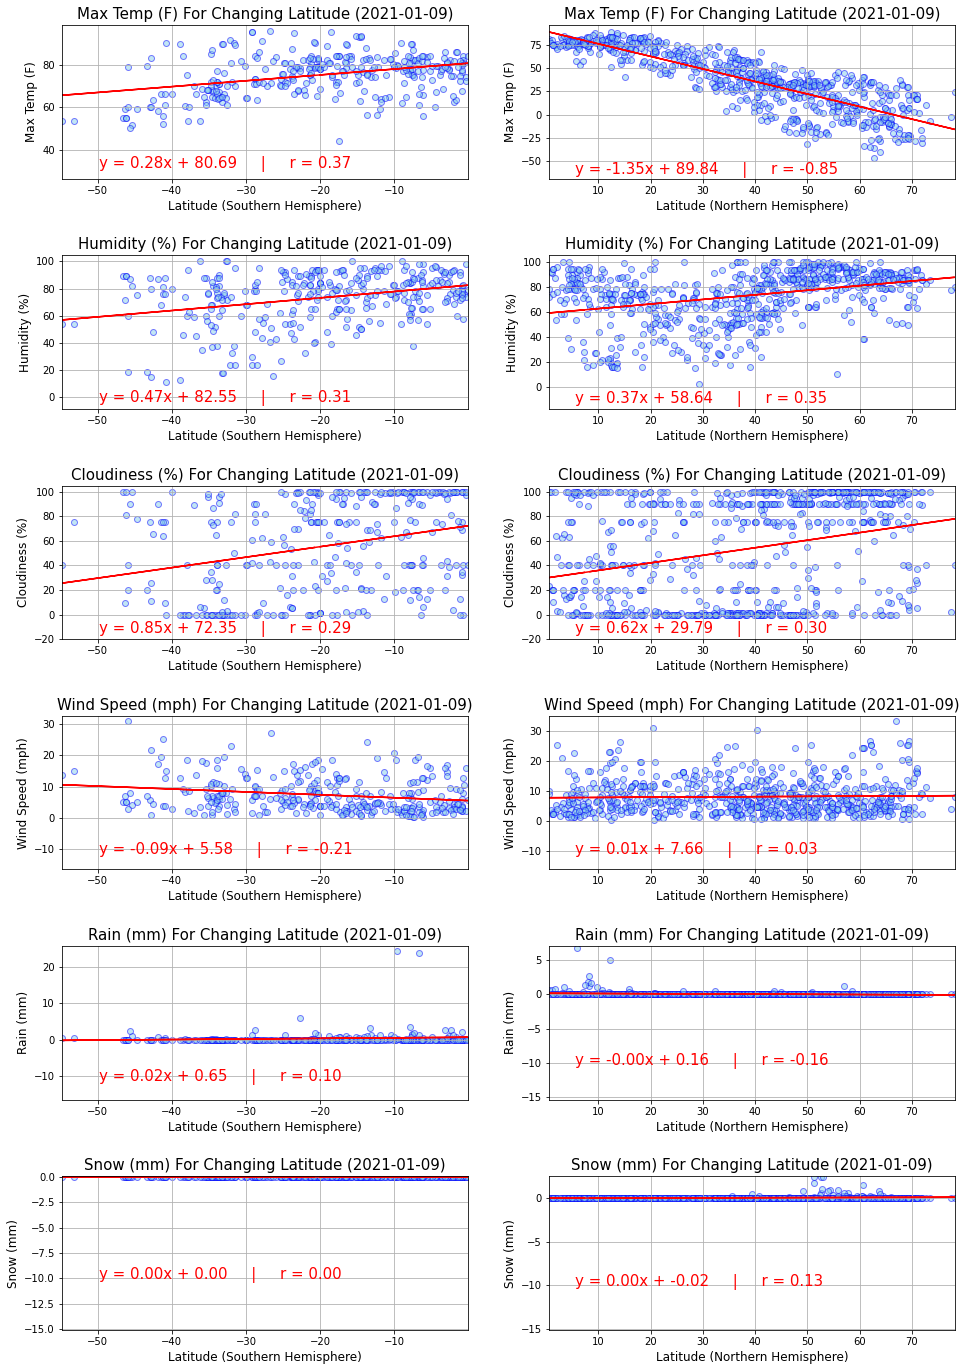

In [18]:
# Figure and axes
fig, ax = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))
fig.subplots_adjust(hspace=0.5) # add horizontal spacing

# Weather subplots
for i in range(n_cols):
    weather_linreg(weather_feats[i], data=south_weather, ax=ax[i][0], x_suffix=' (Southern Hemisphere)')
    weather_linreg(weather_feats[i], data=north_weather, ax=ax[i][1], x_suffix=' (Northern Hemisphere)')

### Weather Heatmaps

In [19]:
# For Jupyterlab
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter lab build

In [26]:
def weather_heatmap(data, measurement, center=(30.0, 31.0), zoom_level=1.5, point_radius=3, max_intensity=300):
    
    """
    Plot a heatmap of a specified weather measurement using the Google Maps API.
    
    Args:
        [1] data (Pandas dataframe) - weather data
        [2] measurement (str) - name of weather measurement
        [3] center (tuple(float, float)) - coordinates for map center
        [4] zoom_level (float) - map zoom
        [5] point_radius - heat radius
        [6] max_intensity - max value for heat scale
        
    Returns:
        [Google Maps figure] weather heatmap
    """
    
    # Locations and measurements
    locations = data[['Latitude', 'Longitude']]
    weights = data[measurement].apply(lambda t: max(t, 0)) # replace negative vals with 0

    # Heatmap
    heatmap_layer = gmaps.heatmap_layer(locations, weights, dissipating=False,
                                        point_radius=point_radius, max_intensity=max_intensity)
    fig = gmaps.figure(center=center, zoom_level=zoom_level)
    fig.add_layer(heatmap_layer)
    print(measurement)
    return fig


# Max temp heatmap
weather_heatmap(weather, weather_feats[0])

Max Temp


Figure(layout=FigureLayout(height='420px'))

In [27]:
# Humidity heatmap
weather_heatmap(weather, weather_feats[1])

Humidity


Figure(layout=FigureLayout(height='420px'))

In [39]:
# Cloudiness heatmap
weather_heatmap(weather, weather_feats[2])

Cloudiness


Figure(layout=FigureLayout(height='420px'))

In [41]:
# Wind speed heatmap
weather_heatmap(weather, weather_feats[3], max_intensity=100)

Wind Speed


Figure(layout=FigureLayout(height='420px'))

In [42]:
# Rain heatmap
weather_heatmap(weather, weather_feats[4], max_intensity=10)

Rain


Figure(layout=FigureLayout(height='420px'))

In [43]:
# Snow heatmap
weather_heatmap(weather, weather_feats[5], max_intensity=10)

Snow


Figure(layout=FigureLayout(height='420px'))